In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import utils.utils as util

import numpy as np
import os, time, sys
import argparse

import utils.pg_utils as q
import model as m

In [2]:
def load_cifar10():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform_train = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomCrop(32, 4),
                    transforms.ToTensor(),
                    normalize
        ])
    transform_test = transforms.Compose([
                    transforms.ToTensor(),
                    normalize
        ])

    # pin_memory=True makes transfering data from host to GPU faster
    trainset = torchvision.datasets.CIFAR10(root='/tmp/cifar10_data', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True)

    testset = torchvision.datasets.CIFAR10(root='/tmp/cifar10_data', train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=True, num_workers=2, pin_memory=True)

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    dataset_sizes = [len(trainset), len(testset)]
    
    return trainloader, testloader, classes, dataset_sizes

In [3]:
import model.tern_resnet_cifar as m
def generate_model():
    return m.tern_resnet20(10)
#     if model_arch == 'resnet-20':
#         if pg:
#             import model.pg_cifar10_resnet_s as m
#             kwargs = {'wbits':wbits, 'abits':abits, \
#                       'pred_bits':pbits, 'sparse_bp':sparse_bp, \
#                       'pact':pact}
#             return m.resnet20(**kwargs)
#         else:
#             import model.quantized_cifar10_resnet as m
#             kwargs = {'wbits':wbits, 'abits':abits, 'pact':pact}
#             return m.resnet20(**kwargs)
#     else:
#         raise NotImplementedError("Model architecture is not supported.")

In [4]:
from time import perf_counter
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
import copy

def train_model(trainloader, dataset_sizes, testloader, net, device):
    if torch.cuda.device_count() > 1:
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        print("Activate multi GPU support.")
        net = nn.DataParallel(net)
    net.to(device)
    # define the loss function
    criterion = (nn.CrossEntropyLoss().cuda() 
                if torch.cuda.is_available() else nn.CrossEntropyLoss())
    # Scale the lr linearly with the batch size. 
    # Should be 0.1 when batch_size=128
    initial_lr = 0.0001
    # initialize the optimizer
    optimizer = optim.SGD(net.parameters(), 
                          lr=initial_lr, 
                          momentum=0.9,
                          weight_decay=1e-4)
    # multiply the lr by 0.1 at 100, 150, and 200 epochs
    div = num_epoch // 4
    lr_decay_milestones = [div*2, div*3]
    scheduler = optim.lr_scheduler.MultiStepLR(
                        optimizer, 
                        milestones=lr_decay_milestones, 
                        gamma=0.1,
                        last_epoch=-1)
    
    # some bookkeeping
    since = perf_counter()
    liveloss = PlotLosses()
    best_acc = 0.0
    best = 0
    
    loss_list = []
    accuracy_list = []
    val_loss_list = []
    val_acc_list = []
    max_val_acc = 0

    for epoch in range(num_epoch): # loop over the dataset multiple times
        ts = perf_counter()
        # set printing functions
        batch_time = util.AverageMeter('Time/batch', ':.3f')
        losses = util.AverageMeter('Loss', ':6.2f')
        top1 = util.AverageMeter('Acc', ':6.2f')
#         progress = util.ProgressMeter(
#                         len(trainloader),
#                         [losses, top1, batch_time],
#                         prefix="Epoch: [{}]".format(epoch+1)
#                         )

        # switch the model to the training mode
        net.train()

        print('current learning rate = {}'.format(optimizer.param_groups[0]['lr']))
        
        # each epoch
        running_loss = 0.0
        running_corrects = 0
        
        end = perf_counter()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            for name, param in net.named_parameters():
                if 'threshold' in name:
                    loss += sigma * torch.norm(param-gtarget)
            loss.backward()
            optimizer.step()

            # measure accuracy and record loss
            _, batch_predicted = torch.max(outputs.data, 1)
            batch_accu = 100.0 * (batch_predicted == labels).sum().item() / labels.size(0)
            batch_loss = loss.item() * inputs.size(0)
            losses.update(loss.item(), labels.size(0))
            top1.update(batch_accu, labels.size(0))
            running_loss += batch_loss
            running_corrects += torch.sum(batch_predicted == labels.data)

            # measure elapsed time
            batch_elapsed = perf_counter() - end
            batch_time.update(batch_elapsed)
            end = perf_counter()

#             progress.display(i) # i = batch id in the epoch
            
            print("\r[Epoch:%d Iteration:%d/%d] Loss: %.3f, Accuracy: %.3f, Time: %.3f"
                  %(epoch+1, i+1, len(trainloader), batch_loss, batch_accu, batch_elapsed), end="")
            sys.stdout.flush()
        
        epoch_loss = running_loss / dataset_sizes[0]
        epoch_acc = running_corrects.double() / dataset_sizes[0]
        loss_list.append(epoch_loss)
        accuracy_list.append(epoch_acc)
        
        # update the learning rate
        scheduler.step()

        # print test accuracy every epochs
#         print('epoch {}'.format(epoch+1))
        val_loss, val_acc = test_accu(testloader, net, device)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best = epoch + 1
            best_model_wts = copy.deepcopy(net.state_dict())

        liveloss.update({
                'log loss': epoch_loss,
                'val_log loss': val_loss,
                'accuracy': epoch_acc,
                'val_accuracy': val_acc
            })     
        liveloss.draw()
        
        tt = perf_counter()
        elapsed = tt - ts
        
        print('Train Loss: {:.5f} Acc: {:.5f}'.format(epoch_loss, epoch_acc))
        print(  'Val Loss: {:.5f} Acc: {:.5f}'.format(val_loss, val_acc))
        print('Epoch Time: {:.4f}'.format(elapsed))
        print('______________________________')
    
    # save the model if required
    if save:
        print("Saving the best trained model.")
        util.save_models(best_model_wts, save_folder, suffix=_ARCH+_SUFFIX+today)

    time_elapsed = perf_counter() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {}, Epoch: {}'.format(best_acc, best))
    
    return loss_list, accuracy_list, val_loss_list, val_acc_list

In [5]:
def test_accu(testloader, net, device):
    net.to(device)
    cnt_out = np.zeros(9) # this 9 is hardcoded for ResNet-20
    cnt_high = np.zeros(9) # this 9 is hardcoded for ResNet-20
    num_out = []
    num_high = []
    def _report_sparsity(m):
        classname = m.__class__.__name__
        if isinstance(m, q.PGConv2d):
            num_out.append(m.num_out)
            num_high.append(m.num_high)

    correct = 0
    total = 0
    running_loss = 0.0
    # switch the model to the evaluation mode
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            
            criterion = (nn.CrossEntropyLoss().cuda() 
                if torch.cuda.is_available() else nn.CrossEntropyLoss())
            loss = criterion(outputs, labels)
            for name, param in net.named_parameters():
                if 'threshold' in name:
                    loss += sigma * torch.norm(param-gtarget)
            running_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            """ calculate statistics per PG layer """
            if pg:
                net.apply(_report_sparsity)
                cnt_out += np.array(num_out)
                cnt_high += np.array(num_high)
                num_out = []
                num_high = []

    print('Accuracy of the network on the 10000 test images: %.1f %%' % (
        100 * correct / total))
    if pg:
        print('Sparsity of the update phase: %.1f %%' % (100-np.sum(cnt_high)*1.0/np.sum(cnt_out)*100))
    
    val_loss = running_loss / total
    val_acc = correct / total
    return val_loss, val_acc

In [6]:
def per_class_test_accu(testloader, classes, net, device):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %.1f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [7]:
from datetime import date
today = date.today().strftime("%y-%m-%d")
print("Today is", today)

batch_size = 128
num_epoch = 200
_LAST_EPOCH = -1 #last_epoch arg is useful for restart
_WEIGHT_DECAY = 1e-4
_ARCH = "ternResNet"
this_file_path = os.path.abspath('./')
save_folder = os.path.join(this_file_path, 'save_CIFAR10_model')
print('Save at', save_folder)

Today is 20-06-22
Save at /media/aperture/Delta/Descartes/Git/dnn-gating/save_CIFAR10_model


In [8]:
path = None
save = True
test = False
wbits = 8
abits = 5
pact = True
pbits = 3
gtarget = 1
sparse_bp = True
pg = False
sigma = 0.001

_SUFFIX = ''

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Available GPUs: {}".format(torch.cuda.device_count()))

print("Create {} model.".format(_ARCH))
net = generate_model()
print(net)

Available GPUs: 1
Create ternResNet model.
CifarResNet : Depth : 20 , Layers for each block : 3
CifarResNet(
  (conv_1_3x3): quanConv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage_1): Sequential(
    (0): ResNetBasicblock(
      (conv_a): quanConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_a): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_b): quanConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBasicblock(
      (conv_a): quanConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_a): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_b): quanConv2d(16, 16, kernel_s

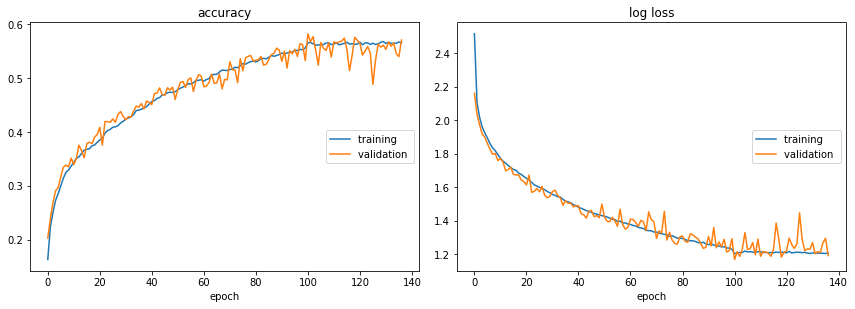

accuracy
	training         	 (min:    0.163, max:    0.568, cur:    0.565)
	validation       	 (min:    0.203, max:    0.582, cur:    0.570)
log loss
	training         	 (min:    1.202, max:    2.516, cur:    1.206)
	validation       	 (min:    1.167, max:    2.161, cur:    1.191)
Train Loss: 1.20608 Acc: 0.56488
Val Loss: 1.19118 Acc: 0.57040
Epoch Time: 14.7317
______________________________
current learning rate = 1e-05
[Epoch:138 Iteration:37/391] Loss: 148.892, Accuracy: 62.500, Time: 0.069

KeyboardInterrupt: 

In [10]:
if path:
    print("@ Load trained model from {}.".format(path))
    net.load_state_dict(torch.load(path))

print("Loading the data.")
trainloader, testloader, classes, dataset_sizes = load_cifar10()
if test:
    print("Mode: Test only.")
    val_loss, val_acc = test_accu(testloader, net, device)
else:
    print("Start training.")
    loss_list, accuracy_list, val_loss_list, val_acc_list = train_model(trainloader, dataset_sizes, testloader, net, device)
    val_loss, val_acc = test_accu(testloader, net, device)
#     per_class_test_accu(testloader, classes, net, device)

In [ ]:
import pickle

filename_los = "./training_lists/" + _ARCH + "los" + _SUFFIX + today + '.data'
filename_acc = "./training_lists/" + _ARCH + "acc" + _SUFFIX + today + '.data'
filename_vallos = "./training_lists/" + _ARCH + "vallos" + _SUFFIX + today + '.data'
filename_valacc = "./training_lists/" + _ARCH + "valacc" + _SUFFIX + today + '.data'

with open(filename_los, 'wb') as filehandle:
    pickle.dump(loss_list, filehandle)
with open(filename_acc, 'wb') as filehandle:
    pickle.dump(accuracy_list, filehandle)
with open(filename_vallos, 'wb') as filehandle:
    pickle.dump(val_loss_list, filehandle)
with open(filename_valacc, 'wb') as filehandle:
    pickle.dump(val_acc_list, filehandle)

In [ ]:
import numpy as np
import random
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(8, 6), dpi=144, constrained_layout=True)
gs = gridspec.GridSpec(1, 2, figure=fig)
xlim = len(loss_list) + 1
x = np.arange(1, xlim)

ax1 = fig.add_subplot(gs[0,0])
ax1.set_xlim(-1, xlim)
ax1.set_ylim(0, 1.02)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.plot(x, accuracy_list, linestyle='-', label='training')
ax1.plot(x, val_acc_list, linestyle='-', label='validation')
plt.yticks(np.arange(0, 1.02, 0.1))
plt.grid(True)
plt.title('Accuracy')
ax1.legend()

ax2 = fig.add_subplot(gs[0,1])
ax2.set_xlim(-1, xlim)
ax2.set_ylim(0, 2.04)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.plot(x, loss_list, linestyle='-', label='training')
ax2.plot(x, val_loss_list, linestyle='-', label='validation')
plt.yticks(np.arange(0, 2.04, 0.2))
plt.grid(True)
plt.title('Loss')
ax2.legend()

plt.draw()
plt.show()